### Package Versions

- **Python version**: `3.9.13`
- **NumPy version**: `1.23.5`
- **Matplotlib version**: `3.4.2`
- **SciPy version**: `1.9.1`
- **Pandas version**: `1.5.3`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, stft
import pandas as pd

## Section a)

In [2]:
def gentone(key='#', T=1, dt=1e-6):
    """ 
    gentone function that can generate the tone associated with any key of the keypad from 0 to 9 plus # and *

    Parameters
    ----------
    key : str, optional
        The key for which the tone is produced, by default is '#'
    T: float, optional
        The duration of signal [seconds], by default 1
    dt: float, optional
        Sampling time step [seconds], by default 1e-6
        By choosing this sampling rate we ensure we are capturing all the frequencies 
        (the sampling rate is faster than Nyquist frequency of highest frequency)

    Returns
    ----------
    t : numpy.ndarray
        Time array from 0 to T
    signal : numpy.ndarray
        Signal points corresponding to the time array
    """

    # Validate input key
    valid_keys = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '*', '#']
    if key not in valid_keys:
        raise ValueError(f"Invalid key '{key}'. Must be one of {valid_keys}.")

    # Time points
    t = np.arange(0, T, dt)

    # Keypad keys in a (4 by 3) matrix
    keypad_keys = np.array([['1', '2', '3'],
                            ['4', '5', '6'],
                            ['7', '8', '9'],
                            ['*', '0', '#']])

    # Frequencies related to each row and column of keypad
    row_frequencies = np.array([697, 770, 852, 941])
    column_frequencies = np.array([1209, 1336, 1477])

    # Find row and column index for the selected key
    ri, cj = np.where(keypad_keys == key)

    # Ensure ri and cj are scalar indices
    ri = ri[0]
    cj = cj[0]

    # Generate signal points 
    signal = 0.5 * (np.sin(2 * np.pi * row_frequencies[ri] * t) +
                    np.sin(2 * np.pi * column_frequencies[cj] * t))

    return t, signal

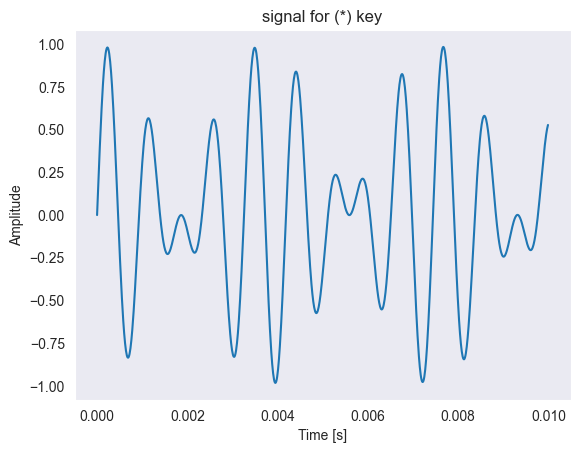

In [3]:
# select the key 
selected_key = '*'
# Generate tone for key '5'
t, signal = gentone(key=selected_key, T=0.01, dt=1e-5)  # Shorter duration and larger time step for quick plotting

# Plot the signal as a function of time
plt.plot(t, signal)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('signal for (' + selected_key + ') key')
plt.grid()
plt.show()


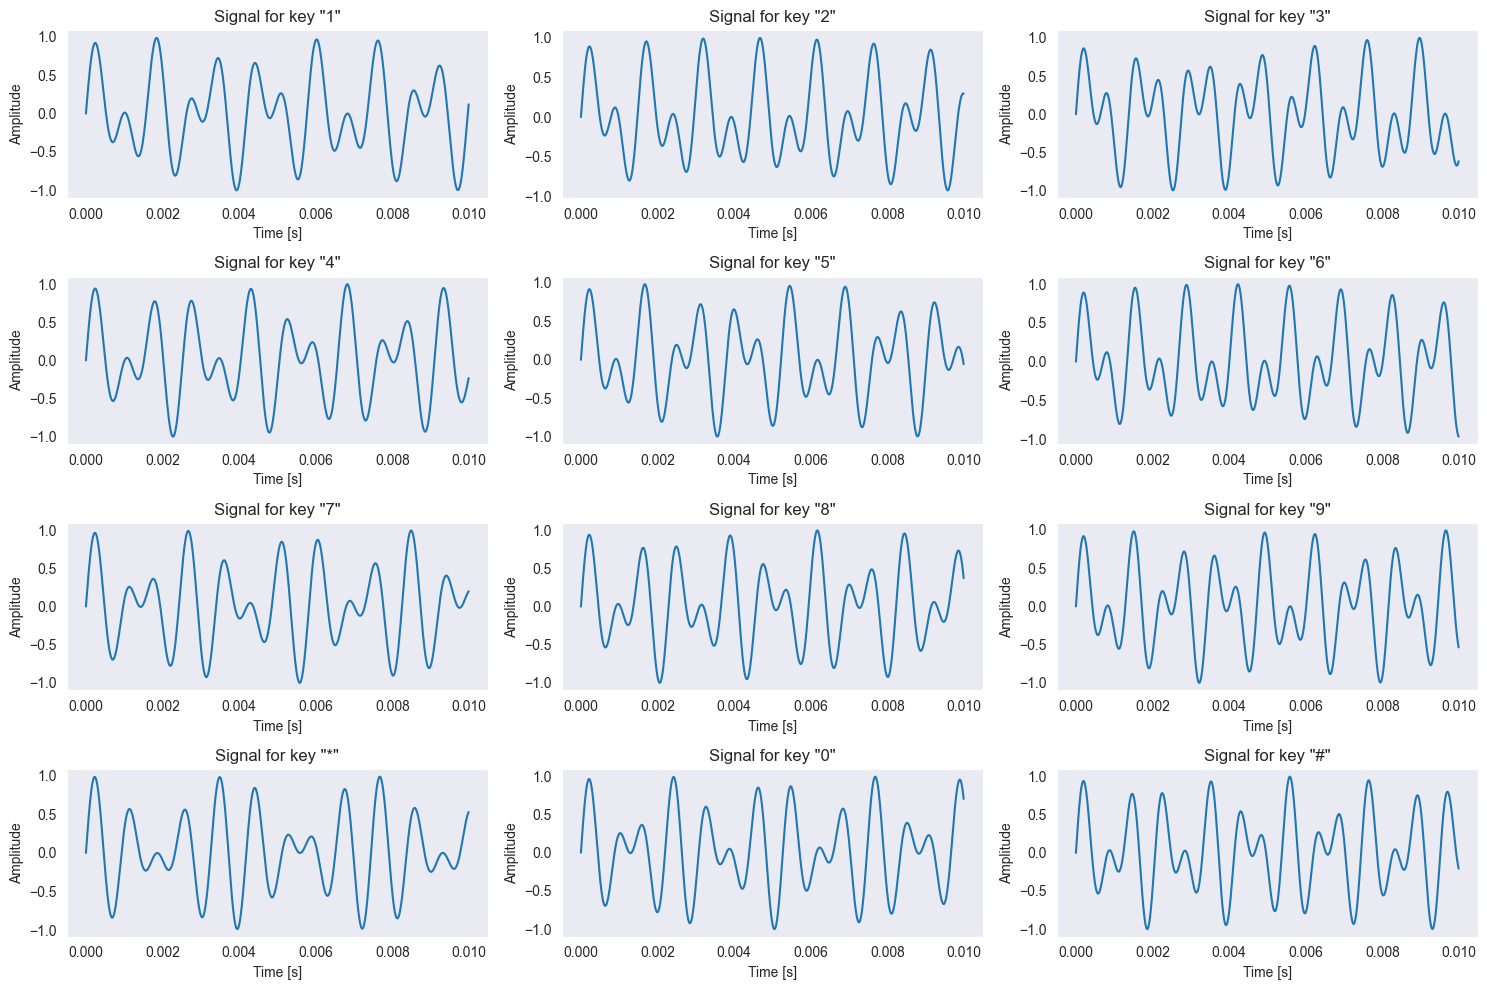

In [4]:
# List of all keypad keys to iterate over and generate their corresponding tones
keypad_keys = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '*', '0', '#']

# Create subplots with a 4 (rows) by 3 (columns) grid to match the physical keypad layout
# figsize defines the size of the entire figure in inches (width, height)
fig, axs = plt.subplots(4, 3, figsize=(15, 10))

# Loop over all keys and generate corresponding plots
for idx, key in enumerate(keypad_keys):
    # Calculate the row and column index for the subplot grid
    # `idx // 3` gives the row index and `idx % 3` gives the column index
    row = idx // 3
    col = idx % 3

    # Generate the tone for the current key using the gentone function
    # T is the total duration (0.01 seconds), dt is the time step (1e-4 seconds)
    t, signal = gentone(key=key, T=0.01, dt=1e-5)  # Shorter duration and larger time step for faster plotting

    # Plot the signal in the corresponding subplot
    axs[row, col].plot(t, signal)
    axs[row, col].set_title(f'Signal for key "{key}"')
    axs[row, col].set_xlabel('Time [s]')
    # Label the y-axis as 'Amplitude' since it represents the signal amplitude
    axs[row, col].set_ylabel('Amplitude')
    # Enable grid for better visualization of the plot
    axs[row, col].grid()

# Adjust the layout to make sure there is enough space between plots to prevent overlap
plt.tight_layout()
# Display the figure with all the subplots
plt.show()


## Section b)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def fft_and_peak_detector(signal, dt):
    """
    Perform FFT on the input signal, plot the FFT spectrum, and detect peaks.

    Parameters
    ----------
    signal : numpy.ndarray
        The signal on which to perform the FFT.
    dt : float
        Time step of the signal in seconds.

    Returns
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Plot of FFT amplitude vs. frequencies between -2000 Hz and 2000 Hz.
    peak_freqs : numpy.ndarray
        Frequencies of peaks detected in the FFT spectrum, rounded to 2 decimal places.
    """

    # Creating result figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Perform FFT using scipy.fft method
    fft_signal = fft(signal)
    # Compute frequency bins corresponding to the FFT values
    freqs = fftfreq(len(signal), d=dt)

    # Plotting the FFT spectrum of the signal
    ax.plot(freqs, np.abs(fft_signal), linestyle='--', color='g', label='FFT Amplitude')

    # Finding the peaks of the FFT using the find_peaks method from scipy.signal
    peaks, properties = find_peaks(np.abs(fft_signal), height=1)
    peak_freqs = freqs[peaks]

    # Select peaks within the frequency range of -2000 to 2000 Hz
    valid_peak_indices = np.logical_and(peak_freqs < 2000, peak_freqs > -2000)
    peak_freqs = peak_freqs[valid_peak_indices]

    # Marking the peaks in the FFT plot
    ax.vlines(x=peak_freqs, ymin=0, ymax=1.1 * np.max(properties['peak_heights']), color='r', linewidth=0.7, label='Detected Peaks')

    # Annotating each detected peak with its frequency
    for peak_freq in peak_freqs:
        ax.text(x=peak_freq, y=0.5 * np.max(properties['peak_heights']), s=f'{peak_freq:.2f} Hz', fontsize=9, color='b')

    # Set plot configurations
    ax.set_xlim(-2000, 2000)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title("FFT of the Selected Signal")
    ax.grid(alpha=0.5)
    ax.legend()

    # Return the axis and rounded peak frequencies
    return ax, np.round(peak_freqs, 2)



In [6]:
def identify_key_from_frequencies(peak_freqs):
    """
    Identify the pressed key on a telephone keypad given the detected frequencies.

    Parameters
    ----------
    peak_freqs : numpy.ndarray
        Array of detected frequencies (in Hz) from the FFT.

    Returns
    ----------
    key : str
        The key that corresponds to the detected frequencies.
    """

    # Define the standard row frequencies of a DTMF keypad (in Hz)
    row_frequencies = [697, 770, 852, 941]
    # Define the standard column frequencies of a DTMF keypad (in Hz)
    column_frequencies = [1209, 1336, 1477]

    # Define tolerance to allow for minor variations in the detected frequencies (in Hz)
    tolerance = 10  # Hz

    # Sort the detected frequencies to differentiate between row and column frequencies
    # Row frequencies are always lower than column frequencies, making sorting useful for classification
    sorted_freqs = np.sort(peak_freqs)

    # Initialize variables to store matched row and column frequencies
    matched_row_freq = None
    matched_col_freq = None

    # Identify the matched row frequency
    # Iterate over each row frequency to find the closest match within the tolerance
    for row_freq in row_frequencies:
        # Check if any frequency in sorted_freqs is within the specified tolerance of the current row frequency
        if any(np.abs(sorted_freqs - row_freq) < tolerance):
            matched_row_freq = row_freq
            break  # Exit the loop once a match is found

    # Identify the matched column frequency
    # Iterate over each column frequency to find the closest match within the tolerance
    for col_freq in column_frequencies:
        # Check if any frequency in sorted_freqs is within the specified tolerance of the current column frequency
        if any(np.abs(sorted_freqs - col_freq) < tolerance):
            matched_col_freq = col_freq
            break  # Exit the loop once a match is found

    # Define the mapping from (row frequency, column frequency) pairs to corresponding keypad keys
    key_mapping = {
        (697, 1209): '1', (697, 1336): '2', (697, 1477): '3',
        (770, 1209): '4', (770, 1336): '5', (770, 1477): '6',
        (852, 1209): '7', (852, 1336): '8', (852, 1477): '9',
        (941, 1209): '*', (941, 1336): '0', (941, 1477): '#'
    }

    # Determine the pressed key using the matched row and column frequencies
    if matched_row_freq is not None and matched_col_freq is not None:
        # Look up the key in the mapping using the matched frequencies
        key = key_mapping.get((matched_row_freq, matched_col_freq), "Unknown key")
    else:
        # If either row or column frequency could not be matched, return "Unknown key"
        key = "Unknown key"

    return key


The `identify_key_from_frequencies` function takes in an array of detected frequencies from an FFT analysis and determines which key on a telephone keypad was pressed based on the standard Dual-Tone Multi-Frequency (DTMF) system.
#### Key Concepts
The function utilizes the DTMF system, which is used in telephone signaling to dial numbers. Each key on the telephone keypad is associated with a unique combination of two frequencies: a **row frequency** and a **column frequency**.

- **Row Frequencies**: 697 Hz, 770 Hz, 852 Hz, 941 Hz
- **Column Frequencies**: 1209 Hz, 1336 Hz, 1477 Hz

The function determines the key pressed by:
1. **Sorting** the detected frequencies to distinguish between row and column frequencies (since row frequencies are always lower than column frequencies).
2. Matching the sorted frequencies with predefined values within a **tolerance** of 10 Hz to account for variations in detection.

#### Function Steps
1. **Define Row and Column Frequencies**:
   The function starts by defining the **row** and **column** frequencies that represent the DTMF keypad. These frequencies are used to identify the pressed key.

2. **Set Frequency Tolerance**:
   The function sets a tolerance of **10 Hz** to accommodate small variations in the detected frequencies due to noise or sampling errors.

3. **Sort the Detected Frequencies**:
   The detected frequencies (`peak_freqs`) are **sorted** to help differentiate between row and column frequencies, as row frequencies are always lower than column frequencies.

4. **Identify Matched Row and Column Frequencies**:
   - The function iterates through the row frequencies and checks if any of the sorted frequencies are within the tolerance range.
   - Similarly, it iterates through the column frequencies to find a matching frequency.
   - The matched row and column frequencies are saved.

5. **Map Frequencies to Keys**:
   The function then uses a **dictionary** (`key_mapping`) to map the combination of matched row and column frequencies to the corresponding key on the keypad.

6. **Return the Identified Key**:
   - If both a row and a column frequency are successfully matched, the function returns the corresponding key using the dictionary.
   - If either of the frequencies could not be matched, the function returns `"Unknown key"`.


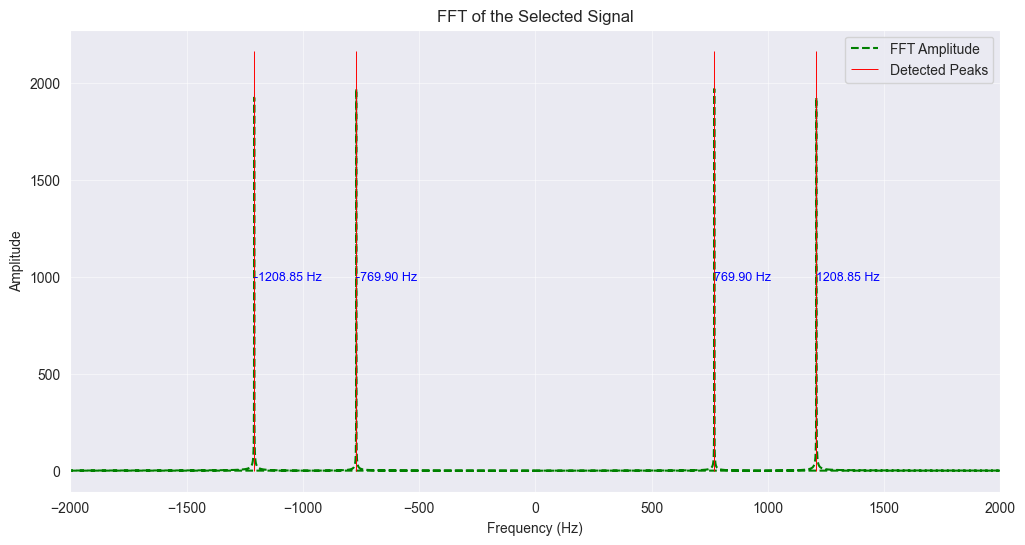

Detected Peak Frequencies (Hz): [  769.9   1208.85 -1208.85  -769.9 ]
Detected Key: 4


In [7]:
# Example usage with the existing signal and FFT analysis
# Generate a sample signal to test the function
t = np.linspace(0, 1, 8000)  # 1 second duration, 8000 samples
signal = 0.5 * (np.sin(2 * np.pi * 770 * t) + np.sin(2 * np.pi * 1209 * t))  # Sample DTMF tone

# Call the FFT function and plot the FFT with peak detection
ax, peak_freqs = fft_and_peak_detector(signal, dt=(t[1] - t[0]))
plt.show()

# Print detected peak frequencies
print("Detected Peak Frequencies (Hz):", peak_freqs)

# Identify the pressed key based on the detected frequencies
detected_key = identify_key_from_frequencies(peak_freqs)
print("Detected Key:", detected_key)

## Section c)

I added Ornstein-Uhlenbeck noise to the signal. The Ornstein-Uhlenbeck noise is modeled by the following stochastic differential equation:

$$
dx = -\gamma x \, dt + g \, \sqrt{dt} \cdot N(0, 1)
$$

Where:
- $ x $ is the current value of the noise process.
- $ \gamma $ is the mean reversion rate.
- $ g $ is the noise intensity factor.
- $N(0, 1) $ is a normally distributed random variable with mean `0` and variance `1`.
- $ \sqrt{dt} $ scales the noise contribution appropriately for the time step size.

The process generates a value at each time step $ t_i $ by applying a combination of:
- **Mean reversion**: $ -\gamma x \, dt $, which pulls the signal back towards zero.
- **Random fluctuation**: $g \, \sqrt{dt} \cdot N(0, 1) $, which adds a random Gaussian perturbation to the signal.

The result is a noise signal that is:
- **Mean-reverting**: It tends to return to zero over time.
- **Smooth**: Compared to white noise, the process evolves more gradually.


In [8]:
import numpy as np

def OU_noise(dt, T, gamma=10, g=0.5):
    """
    Generates an Ornstein–Uhlenbeck (OU) process, a stochastic signal that represents bounded noise.

    Parameters
    ----------
    dt : float
        Time step for the simulation (seconds).
    T : float
        Total time duration of the signal (seconds).
    gamma : float, optional
        Decay rate or mean reversion strength (default is 10). Determines how quickly the process tends towards its mean.
    g : float, optional
        Noise intensity factor, controlling the amplitude of random fluctuations (default is 0.5).

    Returns
    ----------
    ou_noise : numpy.ndarray
        Array representing the Ornstein–Uhlenbeck noise signal over time.
    """

    # Initialize the process variable to start at zero
    current_value = 0.0

    # Calculate the number of time steps
    N = int(T / dt)

    # Initialize an array to store the generated OU noise values
    ou_noise = np.zeros(N)

    # Loop through each time step to generate the OU noise
    for i in range(N):
        # Update the process value based on the Ornstein-Uhlenbeck differential equation
        # dx = -gamma * x * dt + g * sqrt(dt) * N(0, 1)
        current_value = current_value - gamma * current_value * dt + g * np.random.normal() * np.sqrt(dt)

        # Store the updated value in the output array
        ou_noise[i] = current_value

    return ou_noise

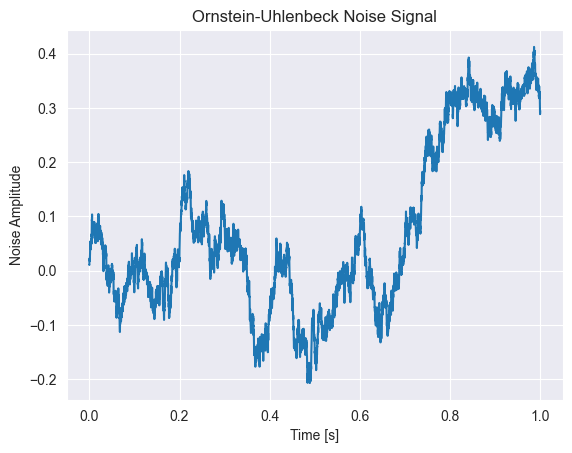

In [9]:
dt =1e-4 # Time step of 1e-4 seconds
T = 1.0    # Total duration of 1 second
gamma = 5  # Decay rate
g = 0.5    # Noise intensity factor

noise_signal = OU_noise(dt, T, gamma, g)

# Plotting the generated Ornstein-Uhlenbeck noise signal
import matplotlib.pyplot as plt
plt.plot(np.arange(0, T, dt), noise_signal)
plt.xlabel('Time [s]')
plt.ylabel('Noise Amplitude')
plt.title('Ornstein-Uhlenbeck Noise Signal')
plt.grid(True)
plt.show()

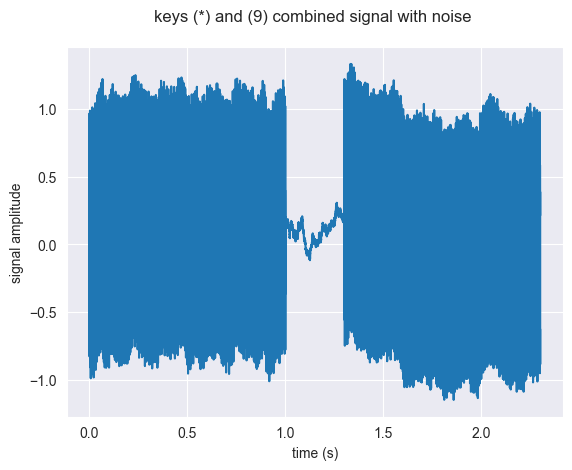

In [10]:
# Select the keys
key1 = '*'
key2 = '9'

delay = 0.3

# creating signals seperately 
t1, signal1 = gentone(key=key1, T= T, dt=dt)
t2, signal2 = gentone(key=key2, T= T, dt=dt)

# combining signals 
combined_signal = np.concatenate((signal1, np.zeros(int(delay/dt)), signal2))
t = np.arange(len(combined_signal))*dt

# generating noise and adding to the combined signal
noise = OU_noise(dt = dt, T= len(t)*dt)
combined_signal = combined_signal + noise


# plotting the result 
plt.close()
plt.title('keys (' + key1 + ') and (' + key2 + ') combined signal with noise \n')
plt.xlabel('time (s)')
plt.ylabel('signal amplitude')
plt.plot(t, combined_signal)
plt.show()

### Section d)

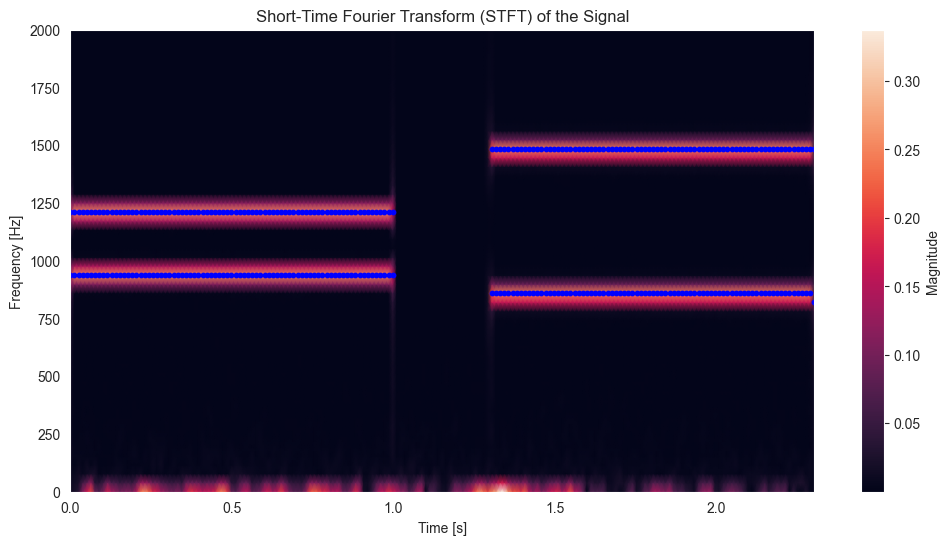

In [11]:

from scipy.signal import stft, find_peaks

# Sampling frequency (Hz), based on the time step (dt)
fs = int(1 / dt)

# Perform Short-Time Fourier Transform (STFT) on the signal
# The stft function calculates the short-time Fourier transform of the signal
freqs, time, stft_signal = stft(combined_signal, fs=fs, nperseg=256)  # nperseg defines the window size for STFT

# Detect frequency peaks in each time window
detected_peaks = []  # List to store detected peaks
tolerance = 10  # Frequency matching tolerance in Hz
threshold = 0.1 * np.max(np.abs(stft_signal))  # Minimum magnitude for considering peaks

# Iterate over each time window in the STFT result
for i in range(stft_signal.shape[1]):
    # Get the magnitude spectrum for the current time window
    spectrum = np.abs(stft_signal[:, i])

    # Detect peaks in the spectrum using find_peaks
    peaks, _ = find_peaks(spectrum, height=threshold)

    # Extract the corresponding frequencies for the detected peaks
    peak_frequencies = freqs[peaks]
    detected_peaks.append(peak_frequencies)

# Plot the spectrogram with detected frequencies
plt.figure(figsize=(12, 6))
plt.pcolormesh(time, freqs, np.abs(stft_signal), shading='gouraud')
plt.title('Short-Time Fourier Transform (STFT) of the Signal')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude')
plt.ylim(0, 2000)  # Limit frequency to DTMF-relevant range

# Overlay detected peaks on the spectrogram
for time_idx, peak_freqs in enumerate(detected_peaks):
    for freq in peak_freqs:
        plt.scatter(time[time_idx], freq, color='blue', s=10)  # Red dots for peaks

plt.grid()
plt.show()


In [12]:
def find_keys_from_peaks(detected_peaks, tolerance=10):
    """
    Map detected frequency peaks from STFT to DTMF keys, ensuring continuity for "Unknown" keys.

    Parameters
    ----------
    detected_peaks : list of numpy.ndarray
        List of detected frequency peaks (one array per time window).
    tolerance : float, optional
        Frequency tolerance to account for detection variations (default is 10 Hz).

    Returns
    ----------
    keys : list of str
        List of identified DTMF keys, one for each time window, replacing "Unknown" with the last valid key.
    """

    # Define DTMF row and column frequencies
    row_frequencies = [697, 770, 852, 941]
    column_frequencies = [1209, 1336, 1477]

    # Define mapping of frequency pairs to keypad keys
    key_mapping = {
        (697, 1209): '1', (697, 1336): '2', (697, 1477): '3',
        (770, 1209): '4', (770, 1336): '5', (770, 1477): '6',
        (852, 1209): '7', (852, 1336): '8', (852, 1477): '9',
        (941, 1209): '*', (941, 1336): '0', (941, 1477): '#'
    }

    # Initialize a list to store identified keys
    keys = []
    # Keep track of the last valid key
    last_valid_key = None
    # Process each set of detected peaks (one per time window)
    for peaks in detected_peaks:
        # Match row and column frequencies
        matched_row = None
        matched_col = None

        # Identify the row frequency
        for row_freq in row_frequencies:
            if any(abs(peak - row_freq) <= tolerance for peak in peaks):
                matched_row = row_freq
                break

        # Identify the column frequency
        for col_freq in column_frequencies:
            if any(abs(peak - col_freq) <= tolerance for peak in peaks):
                matched_col = col_freq
                break

        # Determine the key based on the matched row and column frequencies
        if matched_row is not None and matched_col is not None:
            key = key_mapping.get((matched_row, matched_col), "Unknown")
            last_valid_key = key  # Update the last valid key
        else:
            # Replace "Unknown" with the last valid key, if available
            key = last_valid_key if last_valid_key else "Unknown"

        # Append the identified key to the list
        keys.append(key)

    return keys


In [13]:
peaks = []  # Initialize an empty list to store peaks grouped by pulses
d = round(time[-1] / len(time), 4)  # Calculate the duration of each time step in seconds (rounded to 4 decimals)
n = int(time[-1] / T)  # Determine the number of pulses (dividing total time by the duration of each pulse T)
m = 1
# Loop through all time windows to group peaks by pulses
for i in range(len(time)):
    # Check if the current pulse index (m) is within the total number of pulses
    if n + 1 >= m:
        # If the current time falls within the expected range of the current pulse, append the detected peak
        # Allow for delays between pulses using the `delay` parameter
        if time[i] <= (T * m + d) + delay * (m - 1) and time[i] >= (T * m - d) + delay * (m - 1):
            peaks.append(detected_peaks[i])  # Append the detected peaks for this time window
            m += 1  # Move to the next pulse

# Map the grouped peaks to their corresponding keys
keys = find_keys_from_peaks(peaks)  # Use the previously defined function to map peaks to keys
print("Detected Keys:", keys)  # Print the detected keys for debugging and verification


Detected Keys: ['*', '9']


 So in section c I used keys * and '9' and then added the noise to its signal then I did STFT and I write a code to process the resultant frequency and find the keys that are pressed. As a result the detected keys are match with the keys that I started to use them.

### Section e)

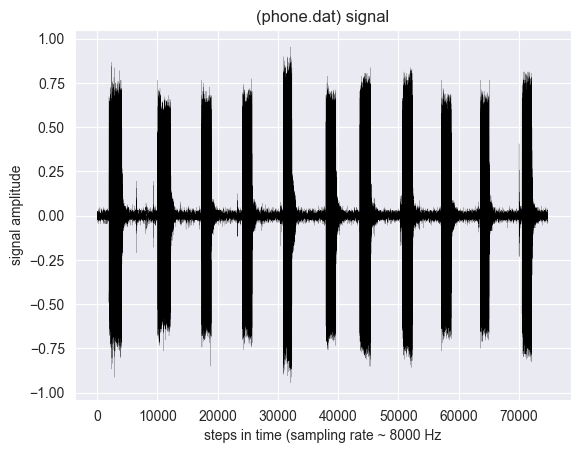

In [14]:
# Openening and reading the phone.dat files
file_data = None
with open('phone.dat', 'r') as file:
    file_data = file.readlines()

# reading the file and converting numbers to float
data = str(file_data[0]).split('\t')
cleaned_data = []
for index, element in enumerate(data):
    if data[index] != '\n':
        cleaned_data.append(float(data[index]))

cleaned_data = np.array(cleaned_data)
plt.plot(cleaned_data, 'k', linewidth = 0.1)
plt.title('(phone.dat) signal')
plt.xlabel('steps in time (sampling rate ~ 8000 Hz')
plt.ylabel('signal amplitude')
plt.show()

in this part I repeated the procces of part (d) and plotted the horizontal lines for each frequency in keypad. Then changed the sampling rate manually to adjust the pattern with lines as much as possible and started to decode the phone number from the pattern and using my find function in the last section.

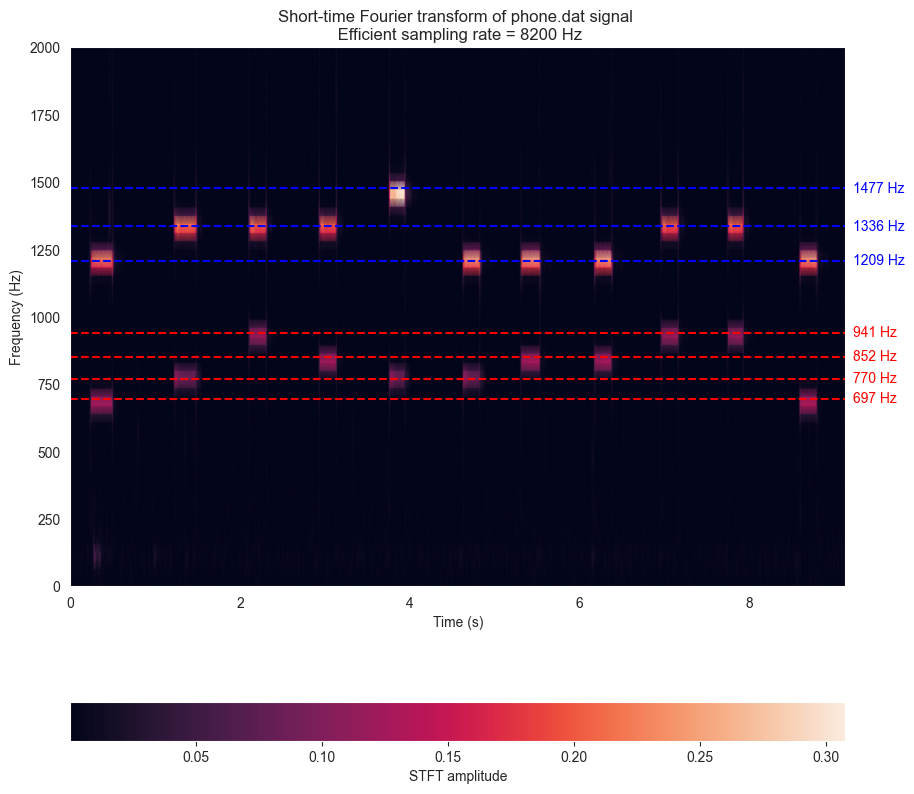

In [15]:
# Define the sampling rate of the signal
sampling_rate = 8200

# Perform the Short-Time Fourier Transform (STFT) to analyze the signal's frequency content over time
freqs, time, stft_signal = stft(cleaned_data, fs=sampling_rate)

# Take the absolute value of the STFT signal to work with magnitudes
stft_signal = np.abs(stft_signal)

# Create a figure for plotting with a 10x10 size
fig = plt.figure(figsize=(10, 10))

# Define the specific row and column frequencies for highlighting
row_frequencies = np.array([697, 770, 852, 941])  # Typical row frequencies for DTMF signals
column_frequencies = np.array([1209, 1336, 1477])  # Typical column frequencies for DTMF signals

# Plot the spectrogram using pcolormesh with STFT data
plt.pcolormesh(time, freqs, stft_signal, shading='gouraud')

# Add horizontal lines to highlight the row frequencies
plt.hlines(y=row_frequencies, xmin=0, xmax=np.max(time), color='r', linestyles='dashed', label='Row frequencies')

# Add horizontal lines to highlight the column frequencies
plt.hlines(y=column_frequencies, xmin=0, xmax=np.max(time), color='b', linestyles='dashed', label='Column frequencies')

# Annotate each row frequency with a label showing its value in Hz
for freq in row_frequencies:
    plt.text(x=np.max(time)*1.01, y=freq, s=f'{freq} Hz', color='r', va='center')

# Annotate each column frequency with a label showing its value in Hz
for freq in column_frequencies:
    plt.text(x=np.max(time)*1.01, y=freq, s=f'{freq} Hz', color='b', va='center')

# Limit the y-axis to show frequencies up to 2000 Hz for clarity
plt.ylim([0, 2000])

# Add a title describing the plot and the effective sampling rate
plt.title('Short-time Fourier transform of phone.dat signal \n Efficient sampling rate = ' + str(sampling_rate) + ' Hz')

# Label the x-axis and y-axis
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Add a colorbar to indicate the amplitude of the STFT signal
plt.colorbar(label='STFT amplitude', location='bottom')

# Display the plot
plt.show()


# Masking out the important time windows 

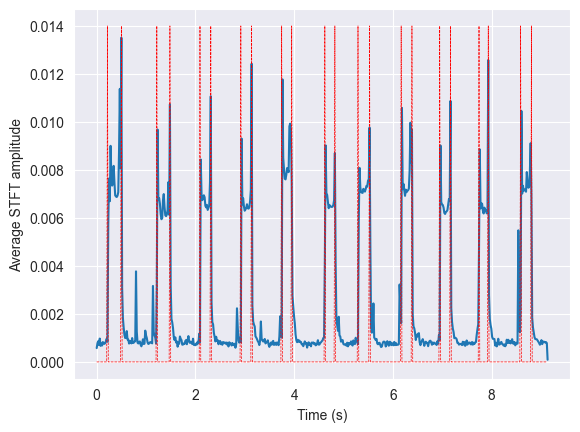

In [24]:
# Create a new figure for the plot
plt.figure()

# Calculate the mean STFT amplitude across all frequencies (average activity over time)
total_activity = np.mean(stft_signal, axis=0)

# Plot the average STFT amplitude over time
plt.plot(time, total_activity, label='Average Activity')

# Create a mask to identify regions where the total activity exceeds a threshold
mask = total_activity > 0.0055
# Plot transitions in the mask using bitwise XOR to detect changes in activity regions
# The result highlights where the activity level transitions across the threshold
plt.plot(
    time[0:-1],                       # Time points for the transitions
    0.014 * np.bitwise_xor(mask[0:-1], mask[1:]),  # Highlight transitions with scaled values
    'r--',                            # Dashed red line style
    linewidth=0.5                     # Thin line for subtle transitions
)

# Add labels to the x-axis and y-axis
plt.xlabel('Time (s)')
plt.ylabel('Average STFT amplitude')

# Display the plot
plt.show()


### Finding Peaks of Each key and Decoding the key number

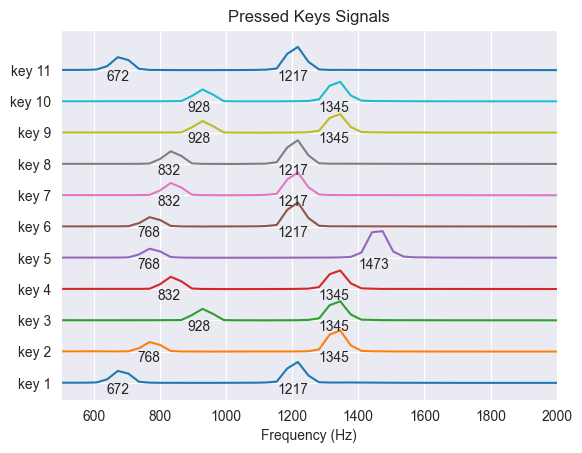

The decoded phone number is : 1-508-647-7001


In [30]:
# Identify transitions (on and off events) in the mask by detecting where it changes
change = np.bitwise_xor(mask[0:-1], mask[1:])  # XOR detects changes between consecutive elements
change = np.where(change)[0]  # Get the indices of the changes

# Separate the indices into "on" and "off" events
on_index = change[0::2]  # Indices where the signal turns on
off_index = change[1::2]  # Indices where the signal turns off

# Initialize an empty string to store the decoded number
number = ''

# Loop through each "on" and "off" pair to analyze the corresponding event
for event in range(len(on_index)):
    # Plot the average STFT signal for the event, offsetting each plot vertically for clarity
    plt.plot(
        freqs,
        np.mean(stft_signal[:, on_index[event]:off_index[event]], axis=1) +0.3 * event,
        '-'
    )

    # Find the peaks in the frequency spectrum during the event
    indices, props = find_peaks(
        np.mean(stft_signal[:, on_index[event]:off_index[event]], axis=1),
        height=0.06  # Minimum height threshold for peaks
    )

    # Annotate the frequencies of the detected peaks on the plot
    plt.text(
        freqs[indices[0]] * 0.95,  # Slightly offset the text horizontally
        0.3 * event - 0.1,  # Position below the event line
        str(int(freqs[indices[0]]))  # First peak frequency as text
    )
    plt.text(
        freqs[indices[1]] * 0.95,
        0.3 * event - 0.1,
        str(int(freqs[indices[1]]))  # Second peak frequency as text
    )

    # Decode the key from the detected peak frequencies
    number += find_keys_from_peaks([freqs[indices]], tolerance=30)[0]

# Set y-axis ticks to label each event with "key N"
plt.yticks(
    np.linspace(0, 0.3 * (len(on_index) - 1), len(on_index)),
    ["key " + str(i + 1) for i in range(len(on_index))]
)

# Label the x-axis and add a title
plt.xlabel("Frequency (Hz)")
plt.title("Pressed Keys Signals")

# Set the x-axis range to focus on relevant frequencies
plt.xlim(500, 2000)

# Display the plot
plt.show()

# Format the decoded phone number into a standard format and print it
print("The decoded phone number is : " + number[0] + "-" + number[1:4] + "-" + number[4:7] + "-" + number[7:11])
